<a href="https://colab.research.google.com/github/cml096/GoogleColabRepo/blob/master/Project_Cap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_excel('Rendimiento CMP V2.xlsx', sheet_name='MinaMLC')

#Preparando Data

##Filtro

In [3]:
df_ = df[df['División de personal'] == 'CMP VALLE DEL HUASCO']

In [4]:
df_test_minera_colorado = df_[df_['Subdivisión de personal'] == 'MINA LOS COLORA']

##Variables no utilizables

In [5]:
df_ = df_test_minera_colorado

In [6]:
filtro = ['R-ef (t/h)',
          'División de personal',
          'Cod. División',
          'Subdivisión de personal',
          'Cod. Subdivisión',
          'Cod. Unidad',
          'Cod. Posición',
          'Fecha de nacimiento',
          'Grupo de personal']

In [7]:
df_.drop(filtro,axis=1,inplace=True)

##Divición "Fecha"

Cambiamos nombre columna "Dia" por "Fecha"

In [8]:
df_ = df_.rename(columns={'Dia':'Fecha'})

Divición de la variable "Fecha"

In [9]:
def dia(fecha):
  aux = str(fecha.date()).split('-')
  dia = str(aux[2])
  return dia

def mes(fecha):
  aux = str(fecha.date()).split('-')
  mes = str(aux[1])
  return mes

def ano(fecha):
  aux = str(fecha.date()).split('-')
  ano = str(aux[0])
  return ano

Anexamos columna "Dia", "Mes" y "Año"

In [10]:
df_['Dia'] = df_.apply(lambda row : dia(row['Fecha']),axis=1)
df_['Mes'] = df_.apply(lambda row : mes(row['Fecha']),axis=1)
df_['Año'] = df_.apply(lambda row : ano(row['Fecha']),axis=1)

##Columna "Turno", "Equipo", "Número de personal", "Fecha de alta" y "Fecha"

In [11]:
df_['Turno'] = df_['Turno'].astype(str)

In [12]:
df_['Equipo'] = df_['Equipo'].astype(str)

In [13]:
df_['Número de personal'] = df_['Número de personal'].astype(str)

In [14]:
df_['Fecha'] = df_['Fecha'].astype(str)

In [15]:
df_['Fecha de alta'] = df_['Fecha de alta'].astype(str)

## "Eficiencia"

Esta eficiencia se ocupara para gráficas e análisis del comportamiento de dicha variables para sacar estimados que nos ayudaran a calcular la próxima variable

In [16]:
filtro = ['Fecha','Turno','Cargas (u)','Movimiento (t)','tdem (seg)','Edad del empleado','Equipo']
df_aux = df_.drop(filtro, axis=1)

Agrupamos por "unidad organizativa" y lo almacenamos en un data frame

In [17]:
group = df_aux.groupby(['Unidad organizativa']).max()
df_group = pd.DataFrame(group)

In [18]:
#df_group

Creamos un array que contiene las tefe max de cada Unidad organizativa

In [19]:
def genera(data,filto):
  lista = []
  for index, row in data.iterrows():
    valor = row[filtro]
    lista.append([index,valor])
  return lista

In [20]:
filtro = ['tefe (seg)']
max_por_unidad = genera(df_group,filtro)

Agregamos la columna "Eficiencia" que generaremos con la fórmula
* (tefe x c/a tupla)*100/tefe_max = porcentaje de eficiencia en dicho día

In [21]:
def rellena(data,lista,filtro):
  aux = []
  for index, row in data.iterrows():
    unidad = row['Unidad organizativa']
    valor = row[filtro]
    for unidad_max,valor_max in lista:
      if unidad == unidad_max:
        if float(valor_max.values) == 0:
          aux.append(0.0)
        else:
          resultado = (valor)/valor_max
          aux.append(float(resultado.values))
  return aux

In [22]:
eficiencia = rellena(df_,max_por_unidad,filtro)

Le agregamos una columna al data frame

In [23]:
df_['Eficiencia'] = eficiencia

### "Eficiencia (bin)"

Variable que será asignada al campo y, variable a predecir

In [24]:
group = df_aux.groupby(['Unidad organizativa']).median()
df_group = pd.DataFrame(group)

In [25]:
media_por_unidad = genera(df_group,filtro)

Generaremos una función la cual será la encargada de rellenar un arreglo de 1 y 0 el cual lo retornara, acá compararemos cada tefe (seg) en x unidad organizativa con la mediana tefe (seg) pro cada unidad sacada anteriormente.

In [26]:
def rellena_binaria(data,lista,filtro):
  aux = []
  for index, row in data.iterrows():
    unidad = row['Unidad organizativa']
    valor = row[filtro].values
    for unidad_median,valor_median in lista:
      valor_median = valor_median.values
      if unidad == unidad_median:
        if valor >= valor_median:
          aux.append(1)
        elif valor < valor_median:
          aux.append(0)
  return aux

In [27]:
eficiencia_binaria = rellena_binaria(df_,media_por_unidad,filtro)

In [28]:
df_['Eficiencia (bin)'] = eficiencia_binaria

##"Demora"

In [29]:
filtro = ['Fecha','Turno','Cargas (u)','Movimiento (t)','tefe (seg)','Edad del empleado','Equipo','Eficiencia (bin)','Eficiencia']
df_aux = df_.drop(filtro, axis=1)

agrupamos por unidad organizativa y calculamos la maxima tdem (seg)

In [30]:
group = df_aux.groupby(['Unidad organizativa']).max()
df_group = pd.DataFrame(group)

In [31]:
#df_group

In [32]:
filtro = ['tdem (seg)']
max_por_unidad = genera(df_group,filtro)

In [33]:
demora = rellena(df_,max_por_unidad,filtro)

In [34]:
df_['Demora'] = demora

###"Demora (bin)"

In [35]:
group = df_aux.groupby(['Unidad organizativa']).median()
df_group = pd.DataFrame(group)

In [36]:
media_por_unidad = genera(df_group,filtro)

Llamamos a la función rellena_binaria() que nos retornara un array relleno de 1 y 0.


*   1 si se cumple
*   0 si no



In [37]:
demora_binaria = rellena_binaria(df_,media_por_unidad,filtro)

In [38]:
df_['Demora (bin)'] = demora_binaria

##Estandarizar

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
filtro = ['Cargas (u)','Movimiento (t)','Edad del empleado','tefe (seg)','tdem (seg)']
aux = df_[filtro]
scaled = pd.DataFrame(StandardScaler().fit_transform(aux), columns= aux.columns)

In [41]:
aux = df_.drop(filtro,axis=1)

scaled.reset_index(drop=True, inplace=True)
aux.reset_index(drop=True, inplace=True)

df_scaled = pd.concat([aux,scaled],axis=1)

##Data a ocupar

In [42]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Fecha                                     1825 non-null   object 
 1   Turno                                     1825 non-null   object 
 2   Equipo                                    1825 non-null   object 
 3   Número de personal                        1825 non-null   object 
 4   Unidad organizativa                       1825 non-null   object 
 5   Posición                                  1825 non-null   object 
 6   Fecha de alta                             1825 non-null   object 
 7   Status empleado para Gestión tiempos per  1825 non-null   object 
 8   Dia                                       1825 non-null   object 
 9   Mes                                       1825 non-null   object 
 10  Año                                 

In [43]:
df_scaled.describe()

,Eficiencia,Eficiencia (bin),Demora,Demora (bin),Cargas (u),Movimiento (t),Edad del empleado,tefe (seg),tdem (seg)
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1.825000e+03,1.825000e+03,1.825000e+03,1.825000e+03
mean,0.539415,0.501918,0.168630,0.503562,-3.650048e-17,1.030530e-16,4.127596e-16,1.727690e-17,6.278083e-17
std,0.272621,0.500133,0.183135,0.500124,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00
min,0.003304,0.000000,0.000000,0.000000,-1.541655e+00,-1.539155e+00,-1.682677e+00,-1.968526e+00,-9.407032e-01
25%,0.319562,0.000000,0.037751,0.000000,-8.208556e-01,-8.153912e-01,-9.933453e-01,-8.166345e-01,-7.094064e-01
50%,0.547570,1.000000,0.113754,1.000000,-1.000562e-01,-9.836510e-02,2.129845e-01,6.657307e-02,-2.835655e-01
75%,0.788964,1.000000,0.240643,1.000000,6.928232e-01,6.566728e-01,9.884822e-01,8.968264e-01,3.902335e-01
max,1.000000,1.000000,1.000000,1.000000,3.551994e+00,3.616645e+00,1.591647e+00,1.893767e+00,7.995096e+00


In [44]:
df_scaled.head()

,Fecha,Turno,Equipo,Número de personal,Unidad organizativa,Posición,Fecha de alta,Status empleado para Gestión tiempos per,Dia,Mes,Año,Eficiencia,Eficiencia (bin),Demora,Demora (bin),Cargas (u),Movimiento (t),Edad del empleado,tefe (seg),tdem (seg)
0,2019-07-01,2,211,20002787,MANTENIMIENTO MINA,ELECTRICO III,2011-10-01,"1 - Evaluación de tiempos, real",01,07,2019,0.505260,0,0.058532,0,0.668797,0.625564,-1.424177,-0.023231,-0.541814
1,2019-07-01,2,213,20000875,MANTENIMIENTO MINA,MECANICO I,1997-03-19,"1 - Evaluación de tiempos, real",01,07,2019,0.131334,0,0.026390,0,-1.277362,-1.268354,0.729983,-1.472102,-0.760860
2,2019-07-01,2,307,20001014,ADMINISTRACION SUPTCIA PLANTAS,OPERADOR ELECTRICO II PLANTA,1998-03-31,"1 - Evaluación de tiempos, real",01,07,2019,0.917188,1,0.197434,1,0.836983,0.853396,1.419314,1.232658,0.431886
3,2019-07-02,1,211,20004895,CAMIONES CAT 793F MLC,OPERADOR III,2013-09-01,"1 - Evaluación de tiempos, real",02,07,2019,0.904444,1,0.103806,0,1.990262,1.963414,0.212984,1.411265,-0.470269
4,2019-07-02,1,213,20003278,MANTENIMIENTO MINA,MECANICO III,2011-04-01,"1 - Evaluación de tiempos, real",02,07,2019,0.069553,0,0.004818,0,-1.397495,-1.392686,-1.079512,-1.711488,-0.907871


# Predicción Tefe (seg)

##Regresión Lineal

Importamos y seleccionamos las variables que ocuparemos en el modelo

In [45]:
from sklearn.model_selection import train_test_split
X = df_scaled[['Turno','Equipo','Movimiento (t)','Cargas (u)','Edad del empleado','Número de personal']]
y = df_scaled['tefe (seg)']

Creamos la data de entrenamiento y test

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

Importamos el modelo de regresion lineal, creamos la regresion y generamos el .fit con la data de entrenamiento

In [47]:
from sklearn import linear_model
modelo = linear_model.LinearRegression()
modelo.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


Predicción con la data de test

In [48]:
y_pred = modelo.predict(X_test)

In [49]:
pd.DataFrame(modelo.coef_,X.columns,columns=['Coefficient'])

,Coefficient
Turno,-0.025161
Equipo,0.007549
Movimiento (t),-0.021779
Cargas (u),1.034880
Edad del empleado,-0.019140
Número de personal,-0.000012


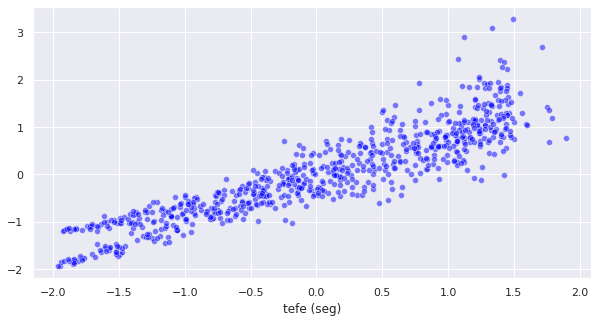

In [50]:
plt.figure(figsize=(10,5))
sns.scatterplot(y_test,y_pred,color='blue',alpha=0.5)

Residuales

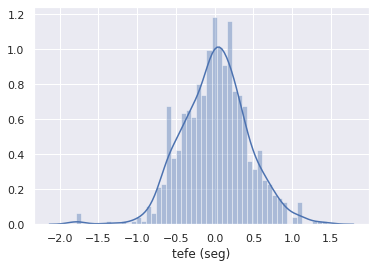

In [51]:
sns.distplot((y_test-y_pred),bins=50)

Error Cuadratico Medio

In [52]:
from sklearn import metrics
print(f'Error Cuadrático Medio: {metrics.mean_squared_error(y_test,y_pred)}')

Error Cuadrático Medio: 0.18060972165442052


Se peude decir que la regresion lineal no en el mejor modelo para este tipo de data

##Regresión Logística

Generamos nuestro data de entrenamiento y le eliminamos las columnas que no ocuparemos en el modolamiento

In [147]:
filtro = ['Eficiencia (bin)','Cargas (u)','Movimiento (t)','Edad del empleado']
train = df_scaled[filtro]

Nos quedamos con los datos numericos

In [148]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Eficiencia (bin)   1825 non-null   int64  
 1   Cargas (u)         1825 non-null   float64
 2   Movimiento (t)     1825 non-null   float64
 3   Edad del empleado  1825 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 57.2 KB


Creamos nuestras variables dummies

In [149]:
unidad = pd.get_dummies(df_scaled['Unidad organizativa'])
posicion = pd.get_dummies(df_scaled['Posición'])
turno = pd.get_dummies(df_scaled['Turno'])
fecha = pd.get_dummies(df_scaled['Fecha'])
numero_personal = pd.get_dummies(df_scaled['Número de personal'])
alta = pd.get_dummies(df_scaled['Fecha de alta'])
status = pd.get_dummies(df_scaled['Status empleado para Gestión tiempos per'])

Agregamos las variables dummies a la data de entrenamiento

In [150]:
train = pd.concat([train,unidad,posicion,turno,fecha,numero_personal,alta,status],axis=1)

In [151]:
train.head()

,Eficiencia (bin),Cargas (u),Movimiento (t),Edad del empleado,ADMINISTRACION SUPTCIA PLANTAS,ALJIBES MLC,CAMIONES CAT 793F MLC,CAMIONES KOMATSU 830E MLC,CARGADORES FRONTALES MLC,GEOLOGIA DE PRODUCCION,INGENIERIA DE PROCESOS,MANTENIMIENTO MINA,MOTONIVELADORAS MLC,PALAS HIDRAULICAS MLC,PLANIFICACION MANTTO. MINA,SERVICIO SOCIAL VHUASCO,SISTEMAS DE CONTROL Y POTENCIA,TRACTORES NEUMATICOS MLC,TRACTORES ORUGA MLC,ASISTENTE GEOLOGIA,AYUDANTE ADMINISTRATIVO,CONTROLADOR PLANIFICACION,ELECTRICO I,ELECTRICO III,INGENIERO DE PROCESOS,JEFE SISTEMAS DE CONTROL Y POTENCIA,MECANICO I,MECANICO III,OPERADOR ELECTRICO II PLANTA,OPERADOR I,OPERADOR II,OPERADOR III,OPERADOR MECANICO III PLANTA,PLANIFICADOR MANTENIMIENTO MINA,1,2,2019-07-01,2019-07-02,2019-07-03,2019-07-04,...,20003244,20003260,20003278,20003408,20003778,20003779,20003858,20004398,20004884,20004895,20005055,20005968,20006912,1988-09-01,1996-07-01,1996-09-23,1996-12-17,1997-02-01,1997-03-19,1997-12-01,1998-03-25,1998-03-31,2003-05-30,2003-06-01,2006-02-16,2006-03-29,2008-08-12,2011-01-17,2011-04-01,2011-07-01,2011-10-01,2012-02-20,2012-11-07,2013-03-01,2013-09-01,2013-11-01,2017-03-08,2019-06-03,"1 - Evaluación de tiempos, real","9 - Evaluación de tiempos, teórico"
0,0,0.668797,0.625564,-1.424177,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,-1.277362,-1.268354,0.729983,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0.836983,0.853396,1.419314,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,1.990262,1.963414,0.212984,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,-1.397495,-1.392686,-1.079512,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


Creamos nuestra data de entrenamiento y de test

In [152]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('Eficiencia (bin)',axis=1),
                                                    train['Eficiencia (bin)'],
                                                    test_size=0.30,random_state=42)

Importamos el modelo, creamos la regresión y entrenamos con nuestra data de entrenamiento

In [123]:
from sklearn.linear_model import LogisticRegression
modelo = LogisticRegression()
modelo.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Predicción con la data de test

In [89]:
y_pred = modelo.predict(X_test)

Evaluacion del modelo

In [90]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       261
           1       0.90      0.87      0.88       287

    accuracy                           0.88       548
   macro avg       0.88      0.88      0.88       548
weighted avg       0.88      0.88      0.88       548



In [91]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
print(cnf_matrix)

[[232  29]
 [ 38 249]]


Text(0.5, 257.44, 'Predicción Eficiencia')

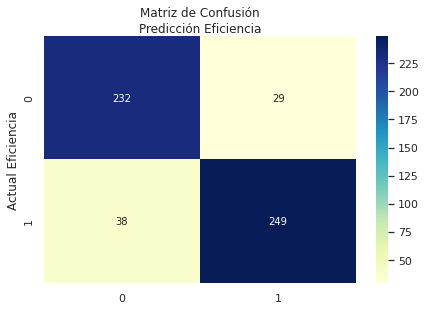

In [92]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de Confusión', y=1.1)
plt.ylabel('Actual Eficiencia')
plt.xlabel('Predicción Eficiencia')

In [93]:
print("Eficiencia")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Eficiencia
Accuracy: 0.8777372262773723
Precision: 0.89568345323741
Recall: 0.867595818815331


Curva ROC
La curva de la característica operativa del receptor (ROC) es un gráfico de la tasa de verdaderos positivos contra la tasa de falsos positivos. Muestra la compensación entre sensibilidad y especificidad.

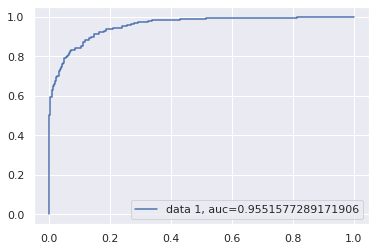

In [95]:
y_pred_proba = modelo.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

La puntuación AUC para el caso es 0,95. La puntuación AUC 1 representa un clasificador perfecto y 0,5 representa un clasificador sin valor.

##Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
modelo = DecisionTreeClassifier()

In [ ]:
modelo.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_pred = modelo.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       261
           1       0.85      0.85      0.85       287

    accuracy                           0.85       548
   macro avg       0.85      0.85      0.85       548
weighted avg       0.85      0.85      0.85       548



In [ ]:
print(confusion_matrix(y_test,y_pred))

[[219  42]
 [ 42 245]]


##Random Forest

In [153]:
from sklearn.ensemble import RandomForestClassifier

In [154]:
modelo = RandomForestClassifier(n_estimators=100)

In [155]:
modelo.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [156]:
y_pred = modelo.predict(X_test)

In [157]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       261
           1       0.89      0.89      0.89       287

    accuracy                           0.88       548
   macro avg       0.88      0.88      0.88       548
weighted avg       0.88      0.88      0.88       548



In [158]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
print(cnf_matrix)

[[229  32]
 [ 32 255]]


Text(0.5, 257.44, 'Predicción Eficiencia')

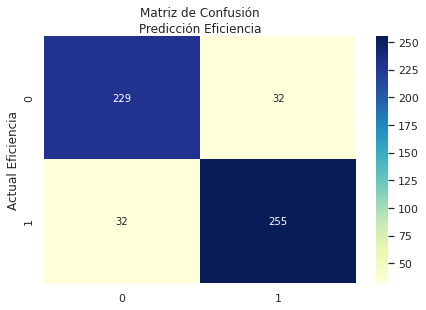

In [159]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de Confusión', y=1.1)
plt.ylabel('Actual Eficiencia')
plt.xlabel('Predicción Eficiencia')

In [160]:
print("Eficiencia")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Eficiencia
Accuracy: 0.8832116788321168
Precision: 0.8885017421602788
Recall: 0.8885017421602788


###Importancia de las variables

In [161]:
importancia = list(modelo.feature_importances_)

In [162]:
for i in range(len(importancia)):
  print(f'--> Variable: {train.columns[i+1]} Importancia: {importancia[i]}')

--> Variable: Cargas (u) Importancia: 0.3252360263681271
--> Variable: Movimiento (t) Importancia: 0.3052136031992976
--> Variable: Edad del empleado Importancia: 0.014677319966475555
--> Variable: ADMINISTRACION SUPTCIA PLANTAS Importancia: 0.0016591826451637967
--> Variable: ALJIBES MLC Importancia: 0.000427315068644714
--> Variable: CAMIONES CAT 793F MLC Importancia: 0.002231548941330314
--> Variable: CAMIONES KOMATSU 830E MLC Importancia: 0.0011173666161608331
--> Variable: CARGADORES FRONTALES MLC Importancia: 0.0006970010444161969
--> Variable: GEOLOGIA DE PRODUCCION Importancia: 0.0007979895891750559
--> Variable: INGENIERIA DE PROCESOS Importancia: 0.00038385885038947417
--> Variable: MANTENIMIENTO MINA Importancia: 0.0020317681836089364
--> Variable: MOTONIVELADORAS MLC Importancia: 0.0029094184386335596
--> Variable: PALAS HIDRAULICAS MLC Importancia: 0.00044724880735982306
--> Variable: PLANIFICACION MANTTO. MINA Importancia: 0.0004707120082004645
--> Variable: SERVICIO SOCI

##PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit(train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
x_pca = pca.transform(train)

In [ ]:
x_pca.shape

(1825, 2)

Text(0.5, 1.0, 'PCA')

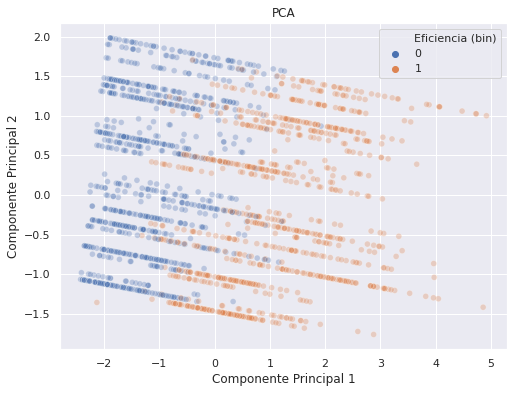

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x_pca[:,0],x_pca[:,1], hue=train['Eficiencia (bin)'], alpha=0.3)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA')

# Predicción Tdem (seg)

##Regresión Lineal

Importamos y seleccionamos las variables que ocuparemos en el modelo

In [ ]:
from sklearn.model_selection import train_test_split
X = df_scaled[['Turno','Equipo','Movimiento (t)','Cargas (u)','Edad del empleado']]
y = df_scaled['tdem (seg)']

Creamos la data de entrenamiento y test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

Importamos el modelo de regresion lineal, creamos la regresion y generamos el .fit con la data de entrenamiento

In [ ]:
from sklearn import linear_model
modelo = linear_model.LinearRegression()
modelo.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


Predicción con la data de test

In [ ]:
y_pred = modelo.predict(X_test)

In [ ]:
pd.DataFrame(modelo.coef_,X.columns,columns=['Coefficient'])

,Coefficient
Turno,0.188476
Equipo,0.002288
Movimiento (t),-2.403934
Cargas (u),2.713557
Edad del empleado,-0.005269


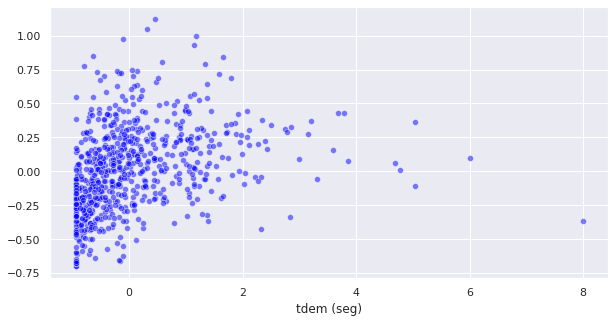

In [ ]:
plt.figure(figsize=(10,5))
sns.scatterplot(y_test,y_pred,color='blue',alpha=0.5)

Residuales

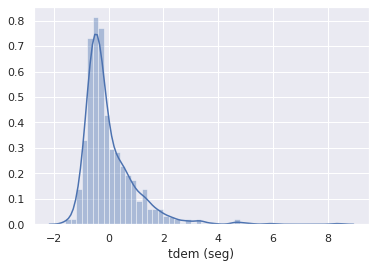

In [ ]:
sns.distplot((y_test-y_pred),bins=50)

Error Cuadratico Medio

In [ ]:
from sklearn import metrics
print(f'Error Cuadrático Medio: {metrics.mean_squared_error(y_test,y_pred)}')

Error Cuadrático Medio: 0.9489034464801674


Se peude decir que la regresion lineal no en el mejor modelo para este tipo de data

##Regresión Logística

Generamos nuestro data de entrenamiento y le eliminamos las columnas que no ocuparemos en el modolamiento

In [132]:
filtro = ['Demora (bin)','Cargas (u)','Movimiento (t)','Edad del empleado']
train = df_scaled[filtro]

In [133]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Demora (bin)       1825 non-null   int64  
 1   Cargas (u)         1825 non-null   float64
 2   Movimiento (t)     1825 non-null   float64
 3   Edad del empleado  1825 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 57.2 KB


Creamos nuestras variables dummies

In [134]:
unidad = pd.get_dummies(df_scaled['Unidad organizativa'])
posicion = pd.get_dummies(df_scaled['Posición'])
turno = pd.get_dummies(df_scaled['Turno'])
fecha = pd.get_dummies(df_scaled['Fecha'])
numero_personal = pd.get_dummies(df_scaled['Número de personal'])
alta = pd.get_dummies(df_scaled['Fecha de alta'])
status = pd.get_dummies(df_scaled['Status empleado para Gestión tiempos per'])

Agregamos las variables dummies a la data de entrenamiento

In [135]:
train = pd.concat([train,unidad,posicion,turno,fecha,numero_personal,alta,status],axis=1)

In [136]:
train.head()

,Demora (bin),Cargas (u),Movimiento (t),Edad del empleado,ADMINISTRACION SUPTCIA PLANTAS,ALJIBES MLC,CAMIONES CAT 793F MLC,CAMIONES KOMATSU 830E MLC,CARGADORES FRONTALES MLC,GEOLOGIA DE PRODUCCION,INGENIERIA DE PROCESOS,MANTENIMIENTO MINA,MOTONIVELADORAS MLC,PALAS HIDRAULICAS MLC,PLANIFICACION MANTTO. MINA,SERVICIO SOCIAL VHUASCO,SISTEMAS DE CONTROL Y POTENCIA,TRACTORES NEUMATICOS MLC,TRACTORES ORUGA MLC,ASISTENTE GEOLOGIA,AYUDANTE ADMINISTRATIVO,CONTROLADOR PLANIFICACION,ELECTRICO I,ELECTRICO III,INGENIERO DE PROCESOS,JEFE SISTEMAS DE CONTROL Y POTENCIA,MECANICO I,MECANICO III,OPERADOR ELECTRICO II PLANTA,OPERADOR I,OPERADOR II,OPERADOR III,OPERADOR MECANICO III PLANTA,PLANIFICADOR MANTENIMIENTO MINA,1,2,2019-07-01,2019-07-02,2019-07-03,2019-07-04,...,20003244,20003260,20003278,20003408,20003778,20003779,20003858,20004398,20004884,20004895,20005055,20005968,20006912,1988-09-01,1996-07-01,1996-09-23,1996-12-17,1997-02-01,1997-03-19,1997-12-01,1998-03-25,1998-03-31,2003-05-30,2003-06-01,2006-02-16,2006-03-29,2008-08-12,2011-01-17,2011-04-01,2011-07-01,2011-10-01,2012-02-20,2012-11-07,2013-03-01,2013-09-01,2013-11-01,2017-03-08,2019-06-03,"1 - Evaluación de tiempos, real","9 - Evaluación de tiempos, teórico"
0,0,0.668797,0.625564,-1.424177,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,-1.277362,-1.268354,0.729983,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0.836983,0.853396,1.419314,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1.990262,1.963414,0.212984,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0,-1.397495,-1.392686,-1.079512,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


Creamos nuestra data de entrenamiento y de test

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('Demora (bin)',axis=1),
                                                    train['Demora (bin)'],
                                                    test_size=0.30,random_state=42)

Importamos el modelo, creamos la regresión y entrenamos con nuestra data de entrenamiento

In [74]:
from sklearn.linear_model import LogisticRegression
modelo = LogisticRegression()
modelo.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Predicción con la data de test

In [75]:
y_pred = modelo.predict(X_test)

Evaluacion del modelo

In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.70      0.70       270
           1       0.71      0.70      0.70       278

    accuracy                           0.70       548
   macro avg       0.70      0.70      0.70       548
weighted avg       0.70      0.70      0.70       548



In [77]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
print(cnf_matrix)

[[189  81]
 [ 84 194]]


Text(0.5, 257.44, 'Predicción Demora')

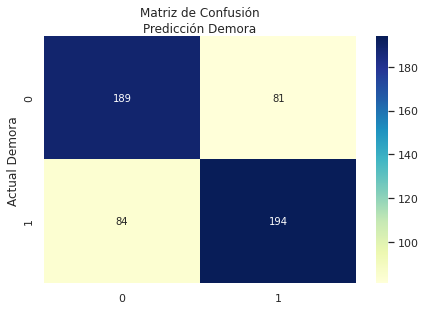

In [78]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de Confusión', y=1.1)
plt.ylabel('Actual Demora')
plt.xlabel('Predicción Demora')

In [81]:
print("Demora")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Demora
Accuracy: 0.698905109489051
Precision: 0.7054545454545454
Recall: 0.697841726618705


##Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
modelo = DecisionTreeClassifier()

In [ ]:
modelo.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_pred = modelo.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62       270
           1       0.63      0.69      0.66       278

    accuracy                           0.64       548
   macro avg       0.64      0.64      0.64       548
weighted avg       0.64      0.64      0.64       548



In [ ]:
print(confusion_matrix(y_test,y_pred))

[[159 111]
 [ 87 191]]


##Random Forest

In [138]:
from sklearn.ensemble import RandomForestClassifier

In [139]:
modelo = RandomForestClassifier(n_estimators=100)

In [140]:
modelo.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [141]:
y_pred = modelo.predict(X_test)

In [142]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.63      0.66       270
           1       0.67      0.73      0.70       278

    accuracy                           0.68       548
   macro avg       0.69      0.68      0.68       548
weighted avg       0.69      0.68      0.68       548



In [143]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
print(cnf_matrix)

[[171  99]
 [ 74 204]]


Text(0.5, 257.44, 'Predicción Demora')

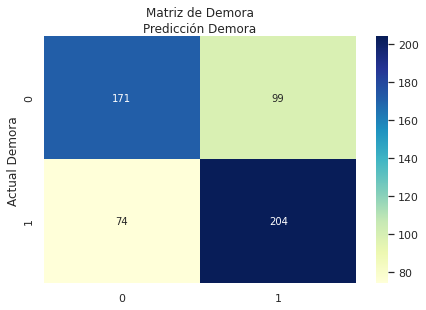

In [146]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de Demora', y=1.1)
plt.ylabel('Actual Demora')
plt.xlabel('Predicción Demora')

In [145]:
print("Demora")
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Demora
Accuracy: 0.6843065693430657
Precision: 0.6732673267326733
Recall: 0.7338129496402878


###Importancia de las variables

In [ ]:
importancia = list(modelo.feature_importances_)

In [ ]:
for i in range(len(importancia)):
  print(f'--> Variable: {train.columns[i+1]} Importancia: {importancia[i]}')

--> Variable: Cargas (u) Importancia: 0.18166279691597353
--> Variable: Movimiento (t) Importancia: 0.1964854972931927
--> Variable: Edad del empleado Importancia: 0.018172518871310526
--> Variable: ADMINISTRACION SUPTCIA PLANTAS Importancia: 0.0016601417272292906
--> Variable: ALJIBES MLC Importancia: 0.0013380132034131254
--> Variable: CAMIONES CAT 793F MLC Importancia: 0.003381475970585395
--> Variable: CAMIONES KOMATSU 830E MLC Importancia: 0.0016329948173863101
--> Variable: CARGADORES FRONTALES MLC Importancia: 0.0009837298654311244
--> Variable: GEOLOGIA DE PRODUCCION Importancia: 0.0014878585780114398
--> Variable: INGENIERIA DE PROCESOS Importancia: 0.0005402486663897111
--> Variable: MANTENIMIENTO MINA Importancia: 0.0034436039696326675
--> Variable: MOTONIVELADORAS MLC Importancia: 0.0017164900146878093
--> Variable: PALAS HIDRAULICAS MLC Importancia: 0.0008017109443043237
--> Variable: PLANIFICACION MANTTO. MINA Importancia: 0.0006139526317577182
--> Variable: SERVICIO SOCI

##PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
pca.fit(train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
x_pca = pca.transform(train)

In [ ]:
x_pca

array([[ 1.13266069,  1.08099939],
       [-1.88372593, -0.59687472],
       [ 0.8557531 , -1.71390945],
       ...,
       [ 0.05194789,  0.66490807],
       [-1.21845897, -0.22172233],
       [-2.51339979, -0.69984712]])

In [ ]:
x_pca.shape

(1825, 2)

Text(0.5, 1.0, 'PCA')

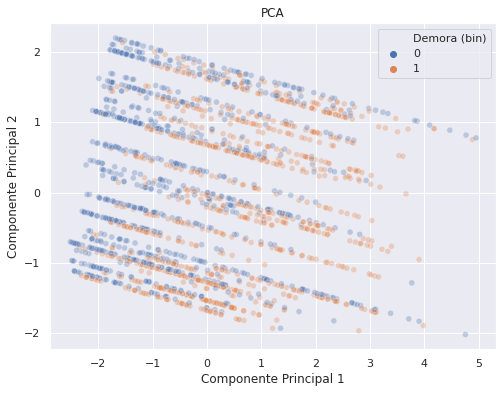

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(x_pca[:,0],x_pca[:,1], hue=train['Demora (bin)'], alpha=0.3)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA')